# Using the `nnde` package to solve a 1-D diffusion problem

## Introduction

This notebook provides a detailed walkthrough of how to solve a partial differential equation using the `nnde` Python package. Each step of the solution process will be illustrated and explained.

## Problem description

Consider the diffusion equation, with diffusion coefficient $D$ and independent variables $\mathbf x=(x,y,z,t)$:

\begin{equation}
    \frac {\partial \psi} {\partial t} = D \nabla^2 \psi
\end{equation}

 In one dimension, this becomes:

\begin{equation}
    \frac {\partial \psi} {\partial t} = D \frac {\partial^2 \psi} {\partial x^2}
\end{equation}

This partial differential equation is 1st order in time, and 2nd order in space.

To determine a particular solution $\psi(x,t)$ to this equation, we must provide boundary conditions. There must be 1 boundary condition for time $t$, and 2 boundary conditions for space $x$. For this example, consider all Dirichlet boundary conditions: an initial profile represented by a half-sine wave, with the boundaries fixed at $0$:

\begin{equation}
    \psi(x,0) = \sin (\pi x)
\end{equation}
\begin{equation}
    \psi(0,t) = 0
\end{equation}
\begin{equation}
    \psi(1,t) = 0
\end{equation}

## Setting up the equation to solve

In order to solve this equation using the `nnde` package, we must prepare Python equivalents for the equation, the boundary conditions, and their derivatives, gradients and Laplacians. We start by rearranging the differential equation into a standard form:

\begin{equation}
    G(\psi, \mathbf x, \nabla \psi, \nabla^2 \psi) = \frac {\partial \psi} {\partial t} - D \frac {\partial^2 \psi} {\partial x^2} = 0
\end{equation}

On the left, the $\nabla$ and $\nabla^2$ operators are with respect to all 4 independent variables, not just the spatial variables.

Similarly, the boundary conditions are cast into a general form:

\begin{equation}
    \psi(0,t) = 0 = f_0(t)
\end{equation}

\begin{equation}
    \psi(1,t) = 0 = f_1(t)
\end{equation}

\begin{equation}
    \psi(x,0) = \sin (\pi x) = Y_0(x)
\end{equation}


In order to compute the parameter gradients required foor training the neural network, we need the derivatives of this equation with respect to its components, where each component is treated as logically independent.

\begin{equation}
    \frac {\partial G} {\partial \psi} = 0
\end{equation}

\begin{equation}
    \frac {\partial G} {\partial \nabla_x \psi} = 0
\end{equation}

\begin{equation}
    \frac {\partial G} {\partial \nabla_t \psi} = 1
\end{equation}

\begin{equation}
    \frac {\partial G} {\partial \nabla^2_x \psi} = -D
\end{equation}

\begin{equation}
    \frac {\partial G} {\partial \nabla^2_t \psi} = 0
\end{equation}


Note that we do not need the derivatives $\partial G/\partial x$ and $\partial G/\partial t$, since $x$ and $t$ are independent of the network parameters.

For the boundary conditions, we need the full gradient components:

\begin{equation}
    \frac {\partial f_0} {\partial x} = 0, \frac {\partial f_0} {\partial t} = 0
\end{equation}

\begin{equation}
    \frac {\partial f_1} {\partial x} = 0, \frac {\partial f_1} {\partial t} = 0
\end{equation}

\begin{equation}
    \frac {\partial Y_0} {\partial x} = \pi \cos (\pi x), \frac {\partial Y_0} {\partial t} = 0
\end{equation}

and Laplacian components:

\begin{equation}
    \frac {\partial^2 f_0} {\partial x^2} = 0, \frac {\partial^2 f_0} {\partial t^2} = 0
\end{equation}

\begin{equation}
    \frac {\partial^2 f_1} {\partial x^2} = 0, \frac {\partial^2 f_1} {\partial t^2} = 0
\end{equation}

\begin{equation}
    \frac {\partial^2 Y_0} {\partial x^2} = -\pi^2 \sin (\pi x), \frac {\partial^2 Y_0} {\partial t^2} = 0
\end{equation}

The `nnde` package expects the Python equivalents of these functions to be supplied in a module of Python code, and that file is used to create a Python object representing the equation, boundary conditions, and all required derivatives. For this example, the module is called `diff1d_halfsine`, and the file `diff1d_halfsine.py` contains the following Python code:

```
from math import cos, pi, sin

# Diffusion coefficient
D = 0.1

def G(xt, Y, delY, del2Y):
    """The differential equation in standard form"""
    (x, t) = xt
    (dY_dx, dY_dt) = delY
    (d2Y_dx2, d2Y_dt2) = del2Y
    return dY_dt - D*d2Y_dx2

def f0(xt):
    """Boundary condition at (x,t) = (0,t)"""
    return 0

def f1(xt):
    """Boundary condition at (x,t) = (1,t)"""
    return 0

def Y0(xt):
    """Boundary condition at (x,t) = (x,0)"""
    (x, t) = xt
    return sin(pi*x)

# 2x2 list of functions for boundary conditions
# There is no BC at t=1.
bc = [[f0, f1], [Y0, None]]

def df0_dx(xt):
    """1st derivative of BC wrt x at (x,t) = (0,t)"""
    return 0

def df0_dt(xt):
    """1st derivative of BC wrt t at (x,t) = (0,t)"""
    return 0

def df1_dx(xt):
    """1st derivative of BC wrt x at (x,t) = (1,t)"""
    return 0

def df1_dt(xt):
    """1st derivative of BC wrt t at (x,t) = (1,t)"""
    return 0

def dY0_dx(xt):
    """1st derivative of BC wrt x at (x,t) = (x,0)"""
    (x, t) = xt
    return pi*cos(pi*x)

def dY0_dt(xt):
    """1st derivative of BC wrt t at (x,t) = (x,0)"""
    return 0

# 2x2x2 list of functions for boundary condition gradient components
delbc = [[[df0_dx, df0_dt], [df1_dx, df1_dt]],
         [[dY0_dx, dY0_dt], [None, None]]]

def d2f0_dx2(xt):
    """2nd derivative of BC wrt x at (x,t) = (0,t)"""
    return 0

def d2f0_dt2(xt):
    """2nd derivative of BC wrt t at (x,t) = (0,t)"""
    return 0

def d2f1_dx2(xt):
    """2nd derivative of BC wrt x at (x,t) = (1,t)"""
    return 0

def d2f1_dt2(xt):
    """2nd derivative of BC wrt t at (x,t) = (1,t)"""
    return 0

def d2Y0_dx2(xt):
    """2nd derivative of BC wrt x at (x,t) = (x,0)"""
    (x, t) = xt
    return -pi**2*sin(pi*x)

def d2Y0_dt2(xt):
    """2nd derivative of BC wrt t at (x,t) = (x,0)"""
    return 0

# 2x2x2 list of functions for boundary condition Laplacian components
del2bc = [[[d2f0_dx2, d2f0_dt2], [d2f1_dx2, d2f1_dt2]],
          [[d2Y0_dx2, d2Y0_dt2], [None, None]]]

def dG_dY(xt, Y, delY, del2Y):
    """Partial of PDE wrt Y"""
    return 0

def dG_dY_dx(xt, Y, delY, del2Y):
    """Partial of PDE wrt dY/dx"""
    return 0

def dG_dY_dt(xt, Y, delY, del2Y):
    """Partial of PDE wrt dY/dt"""
    return 1

# List of functions for derivatives of PDE wrt gradient components
dG_ddelY = [dG_dY_dx, dG_dY_dt]

def dG_d2Y_dx2(xt, Y, delY, del2Y):
    """Partial of PDE wrt d2Y/dx2"""
    return -D

def dG_d2Y_dt2(xt, Y, delY, del2Y):
    """Partial of PDE wrt d2Y/dt2"""
    return 0

# List of functions for derivatives of PDE wrt Laplacian components
dG_ddel2Y = [dG_d2Y_dx2, dG_d2Y_dt2]
```

The current implementation of the code *requires* the definitions of the functions `G`, `dG_dY`, and the lists `bc`, `delbc`, `del2bc`, `dG_ddelY`, and `dG_ddel2Y`. The names of the functions for the individual components of the function lists are arbitrary, but should be set for readability, due to the number of function definitions required.

Once the equation definition module has been created, pass the name of the module as the argument to the equation object constructor:

In [1]:
from nnde.pde2diff import PDE2DIFF
eq = PDE2DIFF('nnde.eq.diff1d_halfsine')

The `PDE2DIFF` class handles 2nd-order PDEs for diffusion problems.

## Create the neural network

Create the neural network object that will be used to solve this PDE:

In [2]:
from nnde.nnpde2diff import NNPDE2DIFF
net = NNPDE2DIFF(eq)

This call creates a single-hidden-layer feedforward neural network with a default number ($H = 10$) of hidden nodes, each with a sigmoid transfer function.

## Create the training data.

Technically, the training data can consist of any number $n \geq 1$ of points $(x,t)$ in the domain $0 \leq x \leq 1$, $t \geq 0$. For simplicity, we will use a $5x5$ grid of evenly-spaced points, flattened into a single list (the order of the points is arbitrary), and converted to a Numpy array:

In [3]:
import numpy as np
from nnde.trainingdata import create_training_grid
nx = nt = 10
xt_train = np.array(create_training_grid([nx, nt]))

## Train the neural network

We now select a training algorithm (`BFGS` selects Broyden-Fletcher-Goldfarb-Shanno minimization for training), and train the network:

In [4]:
np.random.seed(0)  # For the same results, use the same seed.
%timeit -n 1 -r 1 net.train(xt_train, trainalg='BFGS')
# For nx=nt=10, H=10, takes about 6.5 m on an i7 Surface Pro 4.

6min 37s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [5]:
net.res

      fun: 1.2282582096835523e-05
 hess_inv: array([[ 1.03704233e+02,  1.21565436e+01, -4.46456036e+01, ...,
        -1.03725332e+02, -3.22095800e+02,  2.54389901e+02],
       [ 1.21565436e+01,  1.49370290e+01,  5.87819088e+00, ...,
        -1.81695916e+01, -2.41713315e+02,  1.36919649e+02],
       [-4.46456036e+01,  5.87819088e+00,  1.28511352e+02, ...,
         4.16173562e+01, -4.48614464e+02,  1.19277698e+02],
       ...,
       [-1.03725332e+02, -1.81695916e+01,  4.16173563e+01, ...,
         9.69236149e+02,  2.12537684e+03, -1.74838717e+02],
       [-3.22095800e+02, -2.41713315e+02, -4.48614464e+02, ...,
         2.12537684e+03,  9.67041031e+03, -2.92820352e+03],
       [ 2.54389901e+02,  1.36919649e+02,  1.19277698e+02, ...,
        -1.74838717e+02, -2.92820352e+03,  1.79913298e+03]])
      jac: array([ 2.03850186e-06,  8.03265721e-07, -1.50223184e-06,  2.68179770e-06,
        3.75856928e-06, -2.74641604e-06, -7.52426695e-06, -1.66512098e-06,
       -4.96346411e-06, -1.21100197e-

The trained network parameters may be directly printed:

In [6]:
print(net)

nnde.eq.diff1d_halfsine
w = [[-0.08718066  0.44525597  0.09155811  0.02072564  1.72461718  0.98092826
  -0.96366389  1.11126124  1.72400264 -1.60029483]
 [ 1.41507703  0.08181117  1.26191531  0.49742741 -0.75845786  1.09951543
  -2.9700572   0.59448725  0.74138613  1.16653622]]
u = [-0.4815375   0.13555374 -1.6801907   0.09113237 -0.78411665 -0.75864032
 -1.74207886  0.01972771 -0.93175744  2.60996266]
v = [-1.21254919 -0.44230163 -2.36223752 -1.3506185  -5.91397243  0.6179406
 -0.94180365  1.64749083  5.18171741  1.39880683]



In [7]:
m = 2
H = 10
nit = net.phist.shape[0]
phist = net.phist.copy()
whist = phist[:, 0:m*H].reshape(nit, m, H)
uhist = phist[:, m*H:(m + 1)*H].reshape(nit, H)
vhist = phist[:, (m + 1)*H:(m + 2)*H].reshape(nit, H)

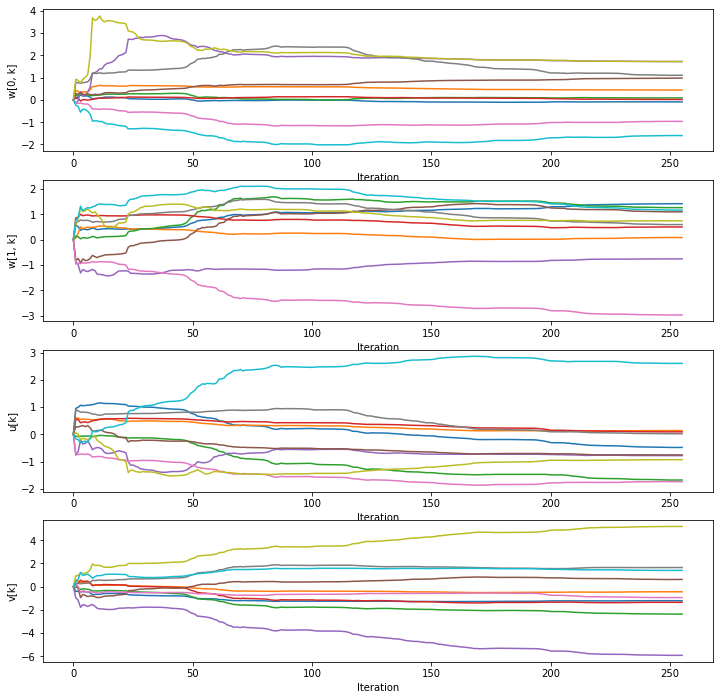

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
plt.subplot(4, 1, 1)
for k in range(H):
    plt.plot(whist[:, 0, k])
plt.xlabel('Iteration')
plt.ylabel('w[0, k]')

plt.subplot(4, 1, 2)
for k in range(H):
    plt.plot(whist[:, 1, k])
plt.xlabel('Iteration')
plt.ylabel('w[1, k]')

plt.subplot(4, 1, 3)
for k in range(H):
    plt.plot(uhist[:, k])
plt.xlabel('Iteration')
plt.ylabel('u[k]')

plt.subplot(4, 1, 4)
for k in range(H):
    plt.plot(vhist[:, k])
plt.xlabel('Iteration')
plt.ylabel('v[k]')

plt.show()

## Run the network to get the trained solution, gradient, and Laplacian components

In [9]:
Yt = net.run(xt_train)
delYt = net.run_gradient(xt_train)
del2Yt = net.run_laplacian(xt_train)

## Compute the analytical solution for comparison

The analytical solution, gradient, and Laplacian are provided in the problem file as the function `Ya`, and the function arrays `delYa`, and `del2Ya`.

In [10]:
Ya = [eq.Ya(xt) for xt in xt_train]
delYa = [[eq.delYa[0](xt), eq.delYa[1](xt)] for xt in xt_train]
del2Ya = [[eq.del2Ya[0](xt), eq.del2Ya[1](xt)] for xt in xt_train]

## Compute the errors in the trained results.

In [11]:
Yterr = Yt - Ya
delYterr = delYt - delYa
del2Yterr = del2Yt - del2Ya

In [ ]:
print('     x          t          Yt         Ya        Yterr')
for ((x, t), Yt_, Ya_, Yterr_) in zip(xt_train, Yt, Ya, Yterr):
    print("%10f %10f %10f %10f %10f" % (x, t, Yt_, Ya_, Yterr_))

In [ ]:
print('     x          t        dYt/dx     dYa/dx   dY/dx err   dYt_dt     dYa_dt    dY/dt err')
for ((x, t), (dYt_dx, dYt_dt), (dYa_dx, dYa_dt), (dY_dx_err, dY_dt_err)) in zip(xt_train, delYt, delYa, delYterr):
    print("%10f %10f %10f %10f %10f %10f %10f %10f" % (x, t, dYt_dx, dYa_dx, dY_dx_err, dYt_dt, dYa_dt, dY_dt_err))

## Reshape arrays for plotting.

In [12]:
x = xt_train[0::nx, 0]
t = xt_train[:nx, 1]
Yerr = Yterr.reshape(nx, nt).T
delYerr = delYterr.reshape(nx, nt, 2)
del2Yerr = del2Yterr.reshape(nx, nt, 2)

## Plot the errors as a function of time.

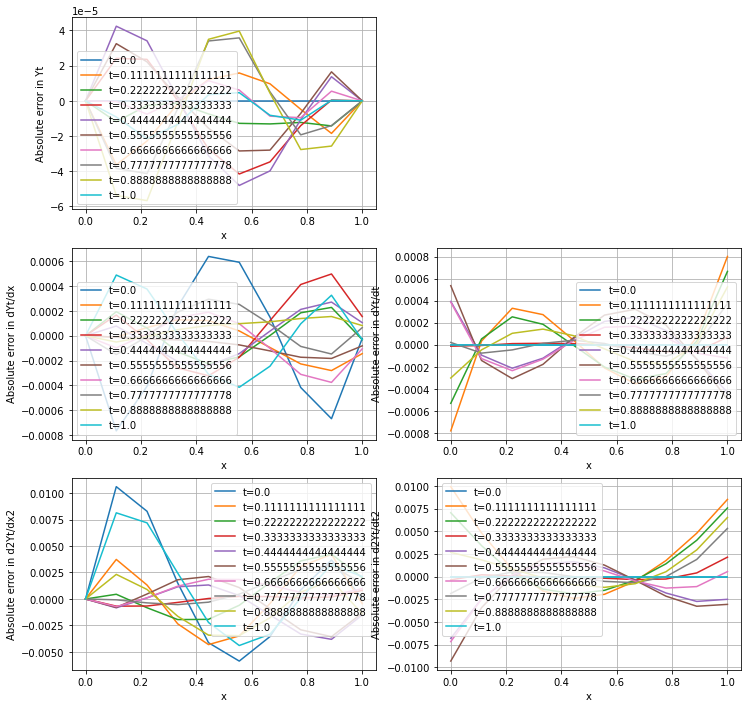

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))

# Plot error in trained solution at each time.
plt.subplot(3, 2, 1)
for i in range(nt):
    plt.plot(x, Yerr[i], label='t=%s' % t[i])
plt.xlabel('x')
plt.ylabel('Absolute error in Yt')
plt.grid()
plt.legend()

# Plot error in trained dY/dx at each time.
plt.subplot(3, 2, 3)
for i in range(nt):
    plt.plot(x, delYerr[i, :, 0], label='t=%s' % t[i])
plt.xlabel('x')
plt.ylabel('Absolute error in dYt/dx')
plt.grid()
plt.legend()

# Plot error in trained dY/dt at each time.
plt.subplot(3, 2, 4)
for i in range(nt):
    plt.plot(x, delYerr[i, :, 1], label='t=%s' % t[i])
plt.xlabel('x')
plt.ylabel('Absolute error in dYt/dt')
plt.grid()
plt.legend()

# Plot error in trained d2Y/dx2 at each time.
plt.subplot(3, 2, 5)
for i in range(nt):
    plt.plot(x, del2Yerr[i, :, 0], label='t=%s' % t[i])
plt.xlabel('x')
plt.ylabel('Absolute error in d2Yt/dx2')
plt.grid()
plt.legend()

# Plot error in trained d2Y/dt2 at each time.
plt.subplot(3, 2, 6)
for i in range(nt):
    plt.plot(x, del2Yerr[i, :, 1], label='t=%s' % t[i])
plt.xlabel('x')
plt.ylabel('Absolute error in d2Yt/dt2')
plt.grid()
plt.legend()

plt.show()

Alternatively, the errors can be plotted as a heat map:

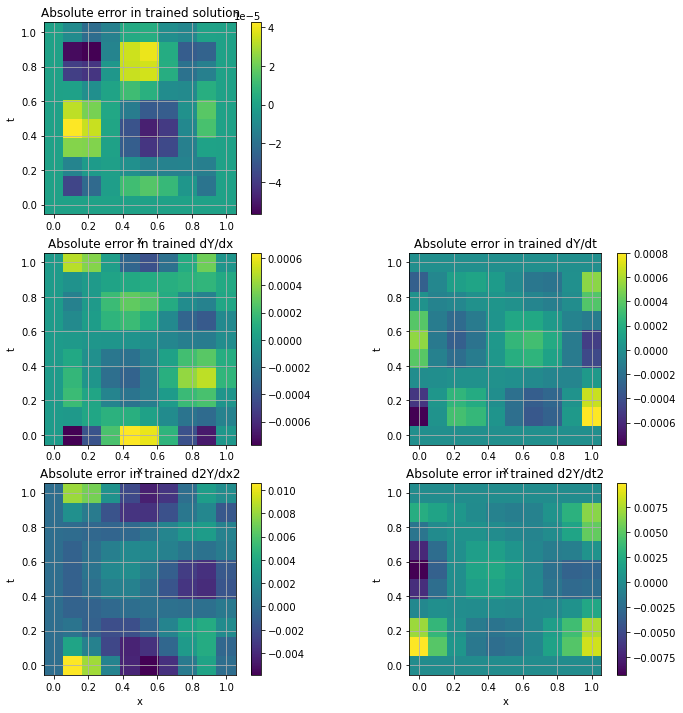

In [14]:
(X, T) = np.meshgrid(x, t)
plt.figure(figsize=(12, 12))

# Plot error in trained solution.
plt.subplot(3, 2, 1)
plt.pcolor(X, T, Yerr, shading='auto')
plt.title('Absolute error in trained solution')
plt.grid()
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.gca().set_aspect('equal')

# Plot error in trained dY/dx.
plt.subplot(3, 2, 3)
plt.pcolor(X, T, delYerr[:, :, 0], shading='auto')
plt.title('Absolute error in trained dY/dx')
plt.grid()
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.gca().set_aspect('equal')

# Plot error in trained dY/dt.
plt.subplot(3, 2, 4)
plt.pcolor(X, T, delYerr[:, :, 1], shading='auto')
plt.title('Absolute error in trained dY/dt')
plt.grid()
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.gca().set_aspect('equal')

# Plot error in trained d2Y/dx2.
plt.subplot(3, 2, 5)
plt.pcolor(X, T, del2Yerr[:, :, 0], shading='auto')
plt.title('Absolute error in trained d2Y/dx2')
plt.grid()
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.gca().set_aspect('equal')

# Plot error in trained d2Y/dt2.
plt.subplot(3, 2, 6)
plt.pcolor(X, T, del2Yerr[:, :, 1], shading='auto')
plt.title('Absolute error in trained d2Y/dt2')
plt.grid()
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.gca().set_aspect('equal')

plt.show()

In [15]:
del2Ya

[[-0.0, 0.0],
 [-0.0, 0.0],
 [-0.0, 0.0],
 [-0.0, 0.0],
 [-0.0, 0.0],
 [-0.0, 0.0],
 [-0.0, 0.0],
 [-0.0, 0.0],
 [-0.0, 0.0],
 [-0.0, 0.0],
 [-3.375603511828233, 0.3331587127667262],
 [-3.025002311257759, 0.29855576124495053],
 [-2.7108156959342598, 0.2675467852313488],
 [-2.4292615281566907, 0.2397585026969233],
 [-2.1769504953926213, 0.21485640190280672],
 [-1.950845310173825, 0.19254071459136116],
 [-1.748224147623907, 0.17254280741479605],
 [-1.5666478804836728, 0.1546219481617897],
 [-1.4039307172137245, 0.13856240785437116],
 [-1.2581138897195763, 0.12417086383047982],
 [-6.344059421527977, 0.6261335678748492],
 [-5.6851446994984665, 0.561101291469999],
 [-5.094667011560081, 0.5028234795937815],
 [-4.565518263935883, 0.4505985915099543],
 [-4.091328632673347, 0.40379795079335773],
 [-3.6663898845302794, 0.3618581774046955],
 [-3.28558666200384, 0.32427440579473593],
 [-2.944334905320782, 0.29059420739835007],
 [-2.6385266701208097, 0.26041214435815996],
 [-2.3644806765554836, 0.2